<a href="https://colab.research.google.com/github/Gratisfo/Parentents-and-children/blob/main/contrastive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Подготовка датасета

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('data.csv')

In [ ]:
data.csv.1

In [ ]:
data

,speaker,text,role,date,title
0,#taratora,"И ты еще, мошенник, смеешь мне указывать! Да з...",parent,1788,krylov-prokazniki
1,#taratora,То есть чего-нибудь хорошенького.,parent,1788,krylov-prokazniki
2,#taratora,"Как, бездельник! да разве не для того он сюда ...",parent,1788,krylov-prokazniki
3,#taratora,"Да его ль вина, бестия, что вы все здесь ходит...",parent,1788,krylov-prokazniki
4,#taratora,Я окончала!.. Как я рада! Элегия эта беспример...,parent,1788,krylov-prokazniki
...,...,...,...,...,...
20297,#sineus,"Ты, сказывают, хотел Славян и прочие народы от...",children,1786,ekaterina-vtoraja-iz-zhizni-rjurika
20298,#truvor,Какие же ты имел при том намерения?,children,1786,ekaterina-vtoraja-iz-zhizni-rjurika
20299,#oskold,"К чему прение тут, где дело само по себе ясно?",children,1786,ekaterina-vtoraja-iz-zhizni-rjurika
20300,#rjurik,"Бодрость духа твоего, князь Вадим, не унывает;...",parent,1786,ekaterina-vtoraja-iz-zhizni-rjurika


#Распределение реплик родителей и детей

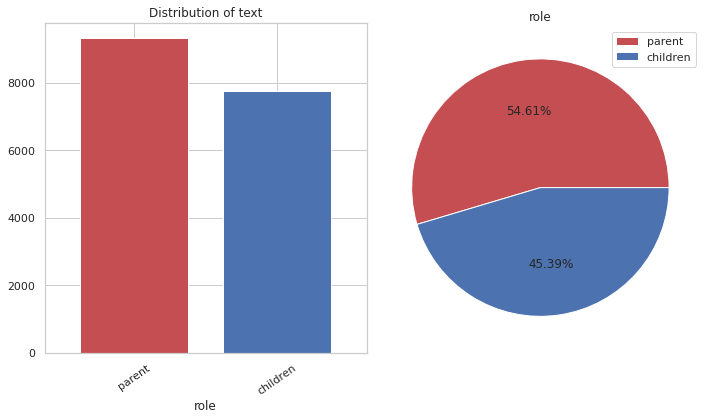

In [ ]:
sns.set(style="whitegrid")


def plot_label_dist(df, col_name, color=["r",  "b"], kind1="bar", kind2="pie"):
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    column_values = list(df[col_name].unique())

    df.groupby(col_name).size().sort_values(ascending=False).plot(
        kind=kind1, width=0.75, title="Distribution of text",
        ax=ax1, rot=35, legend=False, color=color
    )
    ax1.set_xticklabels(column_values)

    df.groupby(col_name).size().sort_values(ascending=False).plot(
        kind=kind2, title=col_name, ax=ax2, autopct="%.2f%%", labels=None, colors=color
    )
    ax2.legend(column_values)
    ax2.axis("off")

    fig.tight_layout()

plot_label_dist(df=data, col_name="role")

#Посчет токенов и предложений

In [ ]:
!pip install razdel

In [ ]:
from razdel import sentenize, tokenize

def get_length_sentences(text):
    segmented_sentences = sentenize(text)
    num_sentences = len(list(segmented_sentences))
    return num_sentences


def get_num_tokens(text):
    tokenized_text = tokenize(text)
    num_tokens = len(list(tokenized_text))
    return num_tokens


def get_num_sentences(text):
    segmented_sentences = sentenize(text)
    num_sentences = len(list(segmented_sentences))
    return num_sentences

In [ ]:
data["sent_num"] = data["text"].apply(get_num_sentences)
data["token_num"] = data["text"].apply(get_num_tokens)

In [ ]:
# вычисления стандартного отклонения, медианы, минимального, среднего и максимального значений

sent_num_subset = data["sent_num"]

print("Standard deviation: %d" % sent_num_subset.std())
print("Median: %d" % sent_num_subset.median())
print("Min value: %d" % sent_num_subset.min())
print("Mean value: %d" % sent_num_subset.mean())
print("Max value: %d" % sent_num_subset.max())

Standard deviation: 1
Median: 1
Min value: 1
Mean value: 1
Max value: 28


In [ ]:
def get_length_sentences(text):
    segmented_sentences = sentenize(text)
    sent_length = []
    for s in list(segmented_sentences):
      sent_length.append(len(list(tokenize(s.text))))
    return sent_length

data["sent_len"] = data["text"].apply(get_length_sentences)

#Распределение длин предложений родителей и детей

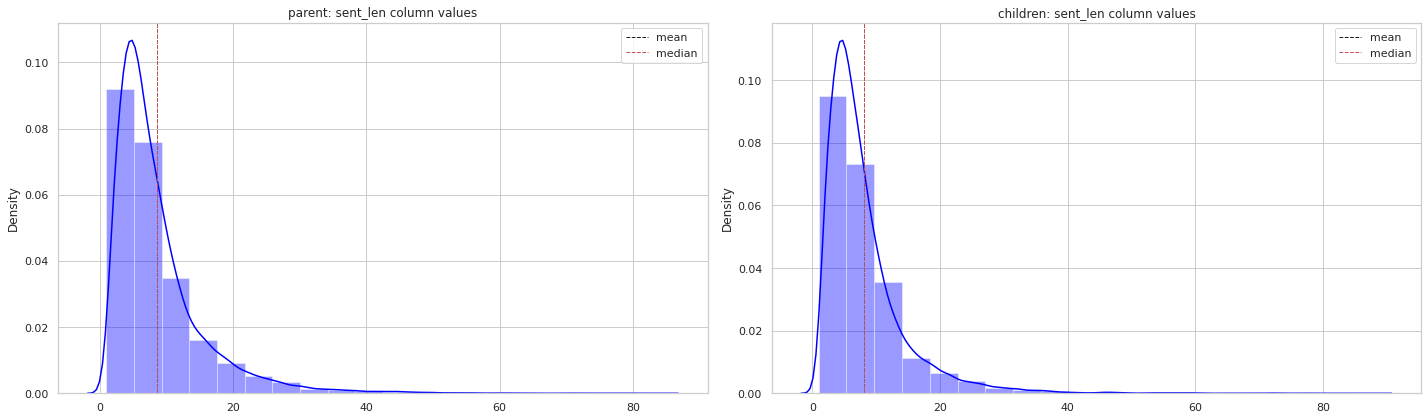

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


def plot_len_dist(data, col_name):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    for i, role in enumerate(['parent', 'children']):
      subset = []
      role_subset = data[data["role"] == role][col_name]
      for r in role_subset:
        subset = subset + r

      sns.distplot(subset, bins=20, color="blue", ax=axes[i])
      axes[i].axvline(
          sum(subset) / len(subset), color="k", linestyle="dashed", linewidth=1, label="mean"
      )
      axes[i].axvline(
          sum(subset) / len(subset), color="r", linestyle="dashed", linewidth=1, label="median"
      )
      axes[i].legend()
      axes[i].set(title="%s: %s column values" % (role, col_name))
    
    fig.tight_layout()

plot_len_dist(data, "sent_len")

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


def plot_dist(df, col_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    for i, role in enumerate(['parent', 'children']):
        role_subset = df[df["role"] == role][col_name]

        sns.distplot(role_subset, bins=20, color="blue", ax=axes[i])
        axes[i].axvline(
            (role_subset).mean(), color="k", linestyle="dashed", linewidth=1, label="mean"
        )
        axes[i].axvline(
            (role_subset).median(), color="r", linestyle="dashed", linewidth=1, label="median"
        )
        axes[i].legend()
        axes[i].set(title="%s: %s column values" % (role, col_name))
    
    fig.tight_layout()

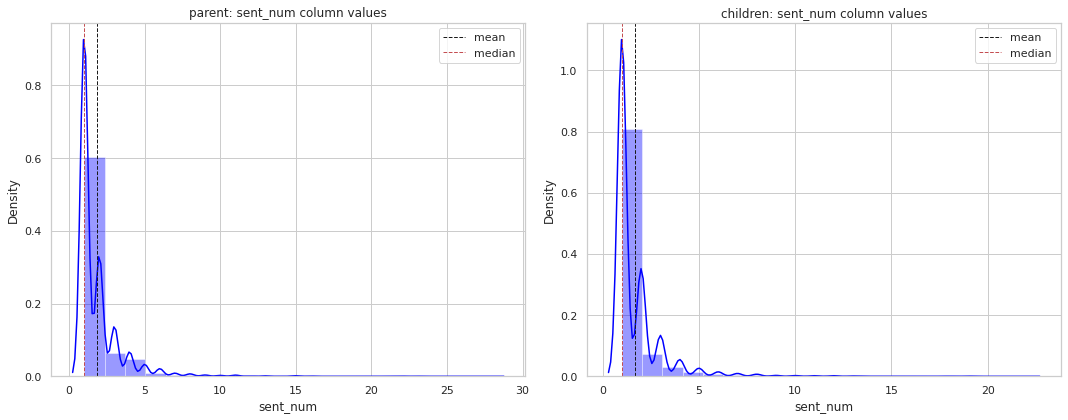

In [ ]:
plot_dist(data, "sent_num")

#Глубина синтаксического дерева

In [ ]:
!pip install --quiet slovnet ipymarkup
!pip install ufal.udpipe
!pip install --upgrade git+https://github.com/udapi/udapi-python.git

In [ ]:
!wget -c https://storage.yandexcloud.net/natasha-slovnet/packs/slovnet_syntax_news_v1.tar
!wget -c https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

In [ ]:
from ipymarkup import show_dep_ascii_markup as show_markup
from navec import Navec
from slovnet import Syntax


navec = Navec.load("navec_news_v1_1B_250K_300d_100q.tar")
syntax = Syntax.load("slovnet_syntax_news_v1.tar")
syntax.navec(navec)


def split_into_chunks(text):
    chunks = [
        [token.text for token in tokenize(sentence.text)] for sentence in sentenize(text)
    ]
    return chunks


def annotate_text(text, syntax=syntax):
    chunks = split_into_chunks(text)
    annotation = [syntax(chunk) for chunk in chunks]
    return annotation

In [ ]:
annotated_example = annotate_text(data['text'][1])

In [ ]:
def convert_text_to_conllu(text, syntax=syntax):
    text_annotation = annotate_text(text, syntax=syntax)
    converted_sentences = []

    for annotated_text in text_annotation:
        converted_sentence = []
        for token in annotated_text.tokens:
            conllu_token = "\t".join(
            [
                token.id, # id токена в предложении
                token.text, # словоформа
                "_", # лемма
                "_", # частеречный тег
                "_", # xpos – Language-specific part-of-speech tag.
                "_", # morphosyntactic description
                token.head_id, # head of the current word
                token.rel, # dependency relation
                "_", # deps – Enhanced dependency graph in the form of a list of head-deprel pairs.
                "_", # misc – any other annotation
            ]
            )
            converted_sentence.append(conllu_token)
        converted_sentences.append("\n".join(converted_sentence))
    return converted_sentences

In [ ]:
from udapi.block.read.conllu import Conllu
from udapi.block.write.textmodetrees import TextModeTrees
from io import StringIO


tree = Conllu(filehandle=StringIO(convert_text_to_conllu(data['text'][3])[0])).read_tree()

writer = TextModeTrees(attributes="ord,form,lemma,upos,feats,deprel,parent")
writer.process_tree(tree)

# sent_id = ?
# text = Да его ль вина , бестия , что вы все здесь ходите , как слоны , и ни одного из вас чорт не придавит ?..
─┮
 │                                          ╭─╼ 1 Да _ _ _ discourse <?#3, ль>
 │                                          ┢─╼ 2 его _ _ _ obj <?#3, ль>
 ┡──────────────────────────────────────────┾ 3 ль _ _ _ root <?, <ROOT>>
 │                                          ┡─┮ 4 вина _ _ _ nsubj <?#3, ль>
 │                                          │ │                                       ╭─╼ 5 , _ _ _ punct <?#6, бестия>
 │                                          │ ┡───────────────────────────────────────┾ 6 бестия _ _ _ acl <?#4, вина>
 │                                          │ │                                       │ ╭─╼ 7 , _ _ _ punct <?#24, придавит>
 │                                          │ │                                       │ ┢─╼ 8 что _ _ _ mark <?#24, придавит>
 │                                          │ │                             

In [ ]:
def tree_depth(tree):
    depth = 0
    stack = [tree]
    while (len(stack)):
        curr_node = stack[0]
        stack.pop(0)
        if curr_node.children:
            depth += 1
        for node in range(len(curr_node.children) -1, -1, -1):
            stack.insert(0, curr_node.children[node])
    return depth

In [ ]:
print("Tree depth of the sentence: %s" % tree_depth(tree))

Tree depth of the sentence: 9


In [ ]:
from tqdm.auto import tqdm


def get_text(tree):
    return " ".join([node.form for node in tree.descendants])


def convert_text_to_depth_features(text):
    res = []
    converted_sentences = convert_text_to_conllu(text)
    for converted_sentence in converted_sentences:
        try:
            curr_sent_tree = Conllu(filehandle=StringIO(converted_sentence)).read_tree()
            curr_sent_depth = tree_depth(curr_sent_tree)
            res.append(
                (get_text(curr_sent_tree), curr_sent_depth, len(curr_sent_tree.descendants)-1)
            )
        except Exception as e:
            continue
    return res

results = []
depth_data = []

for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    text = row["text"]
    depth_features = convert_text_to_depth_features(text)
    depth_data.extend(depth_features)
    results.append(depth_features)

In [ ]:
syn_depth = []
for res in results:
  depth = [r[1] for r in res]
  syn_depth.append(depth)

In [ ]:
 data['synt_depth'] = syn_depth

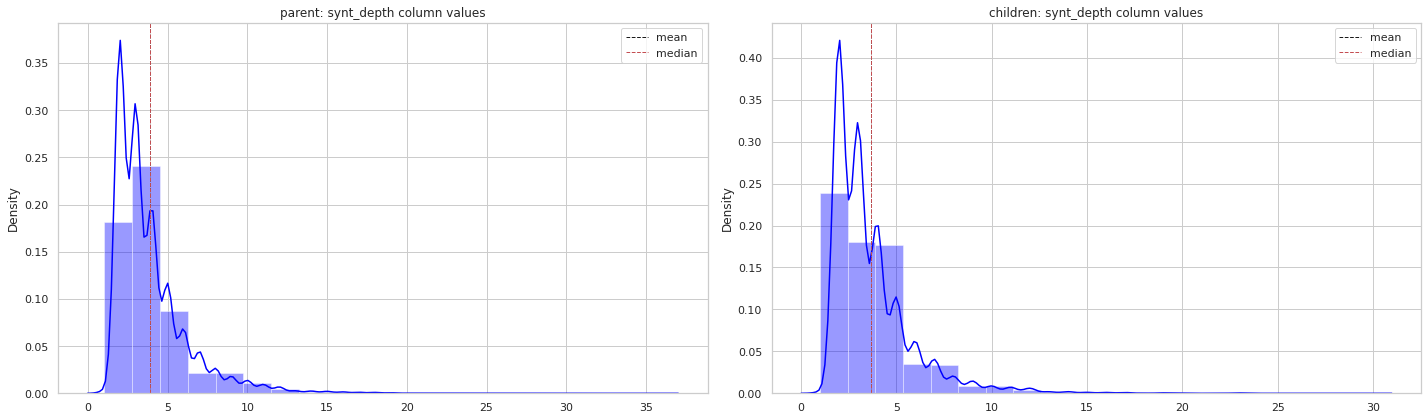

In [ ]:
 # Посмотрим на распредление глубины синтаксических деревьев родителей и детей
 plot_len_dist(data, 'synt_depth')